# Bitcoin Market Trader Sentiment Analysis

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Dataset


In [21]:
from google.colab import files
print("Historical Trader data file:")
hist_data = list(files.upload().keys())[0]
print("Fear Greed Index file:")
sent_data = list(files.upload().keys())[0]                              # file.upload create dict but pd.read_csv take string/file like object as input

Historical Trader data file:


Saving historical_data.csv to historical_data.csv
Fear Greed Index file:


Saving fear_greed_index.csv to fear_greed_index.csv


In [22]:

hist_data = pd.read_csv(hist_data)
hist_data.head(3)

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12


In [23]:
sent_data = pd.read_csv(sent_data)
sent_data.head(3)

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03


# Data Preprocessing

### Historical Data

In [24]:
hist_data1 = hist_data[["Execution Price","Side", "Timestamp IST","Closed PnL","Size USD"]]
hist_data1.head()

,Execution Price,Side,Timestamp IST,Closed PnL,Size USD
0,7.9769,BUY,02-12-2024 22:50,0.0,7872.16
1,7.9800,BUY,02-12-2024 22:50,0.0,127.68
2,7.9855,BUY,02-12-2024 22:50,0.0,1150.63
3,7.9874,BUY,02-12-2024 22:50,0.0,1142.04
4,7.9894,BUY,02-12-2024 22:50,0.0,69.75


In [25]:
hist_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Execution Price  211224 non-null  float64
 1   Side             211224 non-null  object 
 2   Timestamp IST    211224 non-null  object 
 3   Closed PnL       211224 non-null  float64
 4   Size USD         211224 non-null  float64
dtypes: float64(3), object(2)
memory usage: 8.1+ MB


No missing value in the dataset

In [26]:
hist_data1.duplicated().sum()

np.int64(21186)

In [27]:
hist_data1[hist_data1.duplicated()].head()

,Execution Price,Side,Timestamp IST,Closed PnL,Size USD
53,9.04000,SELL,03-12-2024 14:39,606.330666,4520.00
176,241.14000,SELL,03-12-2024 23:38,0.646632,19.29
178,241.14000,SELL,03-12-2024 23:38,0.646632,19.29
215,0.62979,BUY,05-03-2025 12:42,0.000000,17.57
647,3.97770,SELL,30-09-2024 11:19,0.000000,142.32


In [28]:
hist_data1 = hist_data1.drop_duplicates()

In [29]:
hist_data1.duplicated().sum()

np.int64(0)

In [30]:
hist_data1.dtypes

,0
Execution Price,float64
Side,object
Timestamp IST,object
Closed PnL,float64
Size USD,float64


In [31]:
# for extracting date from timestamp it should be of datetime dtype

hist_data1["Timestamp IST"] = hist_data1["Timestamp IST"].astype('datetime64[ns]')
hist_data1["Date"] = hist_data1["Timestamp IST"].dt.date
hist_data1.drop(columns = ["Timestamp IST"],inplace = True)
hist_data1.head(3)

,Execution Price,Side,Closed PnL,Size USD,Date
0,7.9769,BUY,0.0,7872.16,2024-02-12
1,7.9800,BUY,0.0,127.68,2024-02-12
2,7.9855,BUY,0.0,1150.63,2024-02-12


In [32]:
hist_data1['Date'].dtype

dtype('O')

In [33]:
# extracted date from timestamp is of object dtype convert it again in datetime

hist_data1["Date"] = hist_data1["Date"].astype('datetime64[ns]')

In [34]:
hist_data1['Date'].dtype

dtype('<M8[ns]')

In [35]:
# aggregating a per data and coin

datewise_hist_data = hist_data1.groupby("Date", as_index = False).agg({
    "Execution Price" : "mean",
    "Size USD" : "sum",
    "Closed PnL" : "sum",
})
Buy = hist_data1[hist_data1['Side']=='BUY'].groupby("Date").size().to_frame("Buy_Count")         # convert to dataframe with column name Buy_Count and store in Buy
Sell = hist_data1[hist_data1['Side']=='SELL'].groupby("Date").size().to_frame("Sell_Count")


datewise_hist_data = datewise_hist_data.merge(Buy, on='Date', how='left')
datewise_hist_data = datewise_hist_data.merge(Sell, on='Date', how='left')

datewise_hist_data[['Buy_Count', 'Sell_Count']] = datewise_hist_data[['Buy_Count', 'Sell_Count']].fillna(0).astype(int)


In [36]:
datewise_hist_data.head(10)

,Date,Execution Price,Size USD,Closed PnL,Buy_Count,Sell_Count
0,2023-01-05,1898.133333,477.00,0.000000,3,0
1,2023-05-12,11038.300000,50005.83,0.000000,7,2
2,2023-12-14,8031.868818,113203.35,-205.434737,5,6
3,2023-12-15,2.982000,10609.95,-24.632034,2,0
4,2023-12-16,0.384707,15348.77,0.000000,3,0
5,2023-12-17,802.541859,116278.02,304.982785,3,11
6,2023-12-18,2178.100000,31164.18,0.000000,2,0
7,2023-12-19,447.801911,91602.41,1000.538612,5,10
8,2023-12-20,6.722872,141636.79,162.732282,10,8
9,2023-12-21,91.840204,125233.97,537.211402,22,27


### Fear-Greed Index (Sentiment Data)

In [37]:
sent_data[30:40]

,timestamp,value,classification,date
30,1520055000,56,Greed,2018-03-03
31,1520141400,44,Fear,2018-03-04
32,1520227800,55,Greed,2018-03-05
33,1520314200,59,Greed,2018-03-06
34,1520400600,37,Fear,2018-03-07
35,1520487000,39,Fear,2018-03-08
36,1520573400,37,Fear,2018-03-09
37,1520659800,39,Fear,2018-03-10
38,1520746200,40,Fear,2018-03-11
39,1520832600,41,Fear,2018-03-12


In [38]:
sent_data1 = sent_data.drop(columns=["timestamp"])
sent_data1.head(4)

,value,classification,date
0,30,Fear,2018-02-01
1,15,Extreme Fear,2018-02-02
2,40,Fear,2018-02-03
3,24,Extreme Fear,2018-02-04


In [39]:
sent_data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   value           2644 non-null   int64 
 1   classification  2644 non-null   object
 2   date            2644 non-null   object
dtypes: int64(1), object(2)
memory usage: 62.1+ KB


zero missing value, and Date have object datatype

In [40]:
sent_data1["date"] = sent_data1["date"].astype('datetime64[ns]')
sent_data1.dtypes

,0
value,int64
classification,object
date,datetime64[ns]


In [41]:
sent_data1.duplicated().sum()

np.int64(0)

In [42]:
sent_data1 = sent_data1.rename(columns={'date' : 'Date'})

## Merge given datasets

In [43]:
# for merging both dataset need to have same column name with same dtype

print("\nType of 'Date' in datewise_hist_data:", datewise_hist_data['Date'].dtype)
print("Type of 'Date' in sent_data1:", sent_data1['Date'].dtype)


Type of 'Date' in datewise_hist_data: datetime64[ns]
Type of 'Date' in sent_data1: datetime64[ns]


In [44]:
merged_dataset = datewise_hist_data.merge(sent_data1, on= 'Date',how = 'left')

In [45]:
merged_dataset.sample(4)

,Date,Execution Price,Size USD,Closed PnL,Buy_Count,Sell_Count,value,classification
162,2024-06-05,3109.866667,206016.43,968.590380,8,1,75.0,Extreme Greed
431,2025-04-14,27336.858637,12819054.07,45807.159850,417,343,31.0,Fear
108,2024-04-08,11227.107152,1207729.77,-122672.000883,59,67,76.0,Extreme Greed
194,2024-07-10,63684.428571,219984.65,0.000000,0,21,28.0,Fear


# EDA

In [46]:
merged_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             480 non-null    datetime64[ns]
 1   Execution Price  480 non-null    float64       
 2   Size USD         480 non-null    float64       
 3   Closed PnL       480 non-null    float64       
 4   Buy_Count        480 non-null    int64         
 5   Sell_Count       480 non-null    int64         
 6   value            449 non-null    float64       
 7   classification   449 non-null    object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 30.1+ KB


In [47]:
# for eda keep only row with sentiment data(classification, value columns)

dataset = merged_dataset.dropna(subset=['classification', 'value'])


In [48]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 449 entries, 0 to 449
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             449 non-null    datetime64[ns]
 1   Execution Price  449 non-null    float64       
 2   Size USD         449 non-null    float64       
 3   Closed PnL       449 non-null    float64       
 4   Buy_Count        449 non-null    int64         
 5   Sell_Count       449 non-null    int64         
 6   value            449 non-null    float64       
 7   classification   449 non-null    object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 31.6+ KB


In [49]:
dataset.tail()

,Date,Execution Price,Size USD,Closed PnL,Buy_Count,Sell_Count,value,classification
445,2025-04-28,57110.311099,25900675.92,36772.925721,599,714,54.0,Neutral
446,2025-04-29,27145.726438,33279580.20,123054.478988,1044,1007,60.0,Greed
447,2025-04-30,35779.768479,12490918.90,12929.167595,760,264,56.0,Greed
448,2025-05-01,7923.559253,451789.84,3187.719363,65,171,53.0,Neutral
449,2025-05-02,18599.484980,8329172.01,55351.686448,618,516,67.0,Greed


In [50]:
dataset.describe()

,Date,Execution Price,Size USD,Closed PnL,Buy_Count,Sell_Count,value
count,449,449.000000,4.490000e+02,449.000000,449.000000,449.000000,449.000000
mean,2024-08-12 02:24:19.242761728,11372.620635,1.953809e+06,17242.300880,165.565702,174.440980,61.162584
min,2023-01-05 00:00:00,0.000015,1.100000e-01,-427336.928648,0.000000,0.000000,10.000000
25%,2024-04-12 00:00:00,892.907623,8.691437e+04,0.000000,7.000000,6.000000,49.000000
50%,2024-08-09 00:00:00,3433.470732,2.727421e+05,964.253550,27.000000,28.000000,70.000000
75%,2024-12-10 00:00:00,13680.541180,1.115058e+06,7236.972505,145.000000,192.000000,74.000000
max,2025-05-02 00:00:00,68880.000000,4.133083e+07,573752.904775,3982.000000,1871.000000,94.000000
std,NaN,17136.536980,5.269417e+06,64465.004237,368.816436,321.173048,18.207701


Observation:
- Available data is for a 2.5 year for a duration of Jan 2023 to May 2025
- Most of the trading has performed at around a price 11000 to 13000, outlier do exist
- For most of the days traders have experienced profits with an average closing time profit of 17242
- Buy and sell counts for most of the trades are balanced.
- For most of the days the market sentiment is observed greedy


# Visualization

In [51]:
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = (8,4)

/tmp/ipython-input-3048501451.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_Closed_PnL.index, y=avg_Closed_PnL.values, palette=colors)


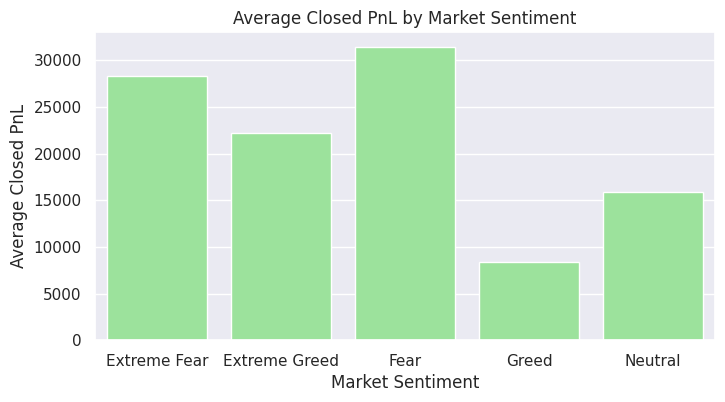

In [52]:

avg_Closed_PnL = dataset.groupby('classification')['Closed PnL'].mean().sort_index()                   # output as avg_Closed_PnL = index(label for row):values ; index=sentiment ; values = avg closed pnl

colors = ['lightgreen' if x >= 0 else 'lightcoral' for x in avg_Closed_PnL.values]                     # lightgreen=positive ; lightcoral=negative value

sns.barplot(x=avg_Closed_PnL.index, y=avg_Closed_PnL.values, palette=colors)
plt.title('Average Closed PnL by Market Sentiment')
plt.ylabel('Average Closed PnL')
plt.xlabel('Market Sentiment')
plt.show()

- More profit is observed to be gained by trader on fear and extreme fear market sentiment
- When the market is greedy less profit is gained compared to other days
- When the market is extremely greedy or neutral, the trader has moderate gain.
- Irrespective of market sentiment traders always have gained profit(lightgreen colour)


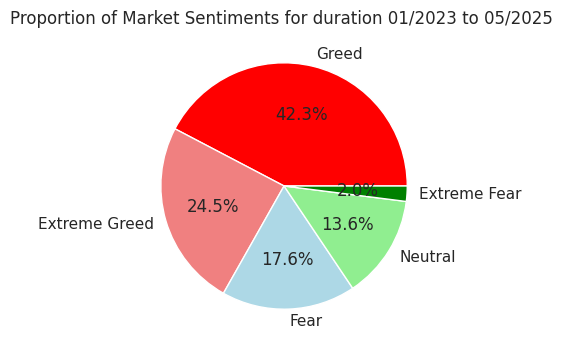

In [53]:
sentiments = dataset['classification'].value_counts()                       # output as sentiments = fear:no. of time fear repeated
plt.pie(sentiments,
        labels=sentiments.index,
        autopct='%1.1f%%',
        colors=['red','lightcoral','lightblue','lightgreen','green'])
plt.title('Proportion of Market Sentiments for duration 01/2023 to 05/2025 ')
plt.show()


- Most of the time the market is observed to be as greedy indicating that less traders gain.
- The frequency of occurrences of extreme fear, fear and neutral market sentiments are almost similar whereas the extreme fear experienced only a few times.
- Most of the trading has done on greedy or neutral days, while a very few trading has observed on fear sentiment


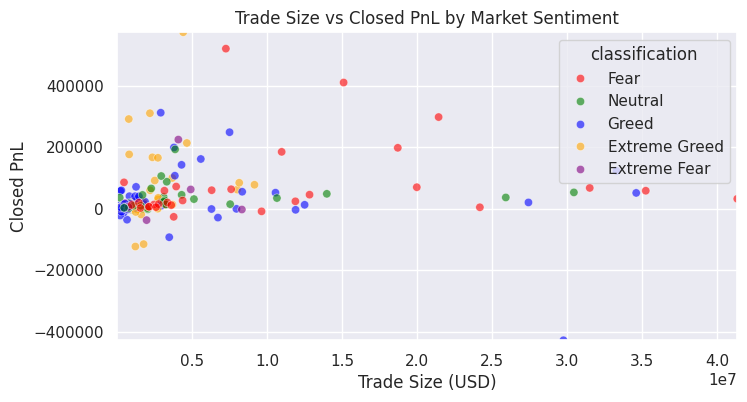

In [54]:
scat_colors = ['red', 'green', 'blue', 'orange', 'purple']

sns.scatterplot(
    data=dataset,
    x='Size USD',
    y='Closed PnL',
    hue='classification',
    alpha=0.6,                                    # transperancy of scatters
    palette=scat_colors )

plt.xlim(dataset['Size USD'].min(), dataset['Size USD'].max())
plt.ylim(dataset['Closed PnL'].min(), dataset['Closed PnL'].max())

plt.title('Trade Size vs Closed PnL by Market Sentiment')
plt.xlabel('Trade Size (USD)')
plt.ylabel('Closed PnL')
plt.show()


- note: 1e7 = 1 * 10^7
- During fear sentiment moderate size trade gives more benefit.
- During extreme(fear or greed) sentiments risk is more, so it's better to do less or avoid trading
- Having more trade size do not ensure profit
